## MCX simulation

In [ ]:
! pip install pmcx
! git clone --recursive https://github.com/fangq/mcx.git
!pip install numpy pmcx jdata bjdata matplotlib
import pmcx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 16.4 MB/s eta 0:00:00
Cloning into 'mcx'...
remote: Enumerating objects: 13205, done.
remote: Counting objects: 100% (1978/1978), done.
remote: Compressing objects: 100% (204/204), done.
remote: Total 13205 (delta 1841), reused 1775 (delta 1774), pack-reused 11227 (from 3)
Receiving objects: 100% (13205/13205), 24.53 MiB | 18.01 MiB/s, done.
Resolving deltas: 100% (9273/9273), done.
Submodule 'filter' (https://github.com/fangq/GPU-ANLM.git) registered for path 'filter'
Submodule 'src/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'src/pybind11'
Cloning into '/content/mcx/filter'...
remote: Enumerating objects: 117, done.        
remote: Counting objects: 100% (10/10), done.        
remote: Compressing objects: 100% (8/8), done.        
remote: Total 117 (delta 4), reused 4 (delta 2), pack-reused 107 (from 1)        
Receiving objects: 100% (117/117), 3.66 MiB | 50.64 MiB/s, done.
Resolving deltas: 100% (59/5

In [ ]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### Define Layer Properties

In [ ]:
# Define GT tissue properties. [HHB, HBO, CCO]
wl = [784, 800, 818, 835, 851, 868, 881, 894]

# skin layer
HbO2_skin = 60;
Hb_skin = 25;
CCO_skin = 8.5;
a_skin = 17.0;
b_skin = 0.7;
g_skin = 0.85;

# scalp layer
HbO2_scalp = 65;
Hb_scalp = 30;
CCO_scalp = 9;
a_scalp = 17.0;
b_scalp = 0.7;
g_scalp = 0.85;

# skull layer
HbO2_skull = 55;
Hb_skull = 20;
CCO_skull = 8;
a_skull = 17.0;
b_skull = 0.7;
g_skull = 0.85;

# brain layer
HbO2_brain = 70;
Hb_brain = 25;
CCO_brain = 7;
a_brain = 17.0;
b_brain = 0.7;
g_brain = 0.85;

### Connect to the google drive & read coefficient

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pmcx
import jdata as jd
from matplotlib import pyplot as plt

Mounted at /content/drive


In [ ]:

def get_coefficient(wavelength, coe_path):
  data = pd.read_excel(coe_path)
  lambda_values = data['Lambda'].values
  idx = np.argmin(np.abs(lambda_values - wavelength))
  HbO2_coef = data.loc[idx, 'HbO2']
  Hb_coef   = data.loc[idx, 'Hb']
  CCO_coef  = data.loc[idx, 'CCO']
  return np.array([HbO2_coef, Hb_coef, CCO_coef])

def get_coefficients(wavelengths, coe_path):
  coefficients = []
  for wl in wavelengths:
    coefficients.append(get_coefficient(wl, coe_path))
  return np.array(coefficients)

In [ ]:
coe_path = '/content/drive/MyDrive/MCX_data/EC.xlsx'
coef = get_coefficients(wl, coe_path)
print(coef) # 8x3 -> [wl1-[HBO2, HB, CCO], wl2-[], wl3-[], ...]

[[ 761.1  1017.03 2097.38]
 [ 865.07  839.66 2261.33]
 [ 978.64  784.68 2340.89]
 [1079.44  780.3  2312.53]
 [1164.21  786.9  2287.3 ]
 [1240.39  812.   2186.63]
 [1287.47  843.57 2052.48]
 [1323.16  876.28 1906.12]]


In [ ]:
def compute_mu_a(E, C):
    C = np.array(C) / 1e6
    E = np.array(E)
    mu_a = np.dot(C, E.T)
    return mu_a

def compute_mu_s(a_list, b_list, g_list, wl):
    r = []
    for i in wl:
        r.append(compute_mu_ss(a_list, b_list, g_list, i))
    return np.array(r)

def compute_mu_ss(a_list, b_list, g_list, wavelength):
    a_list = np.array(a_list)
    b_list = np.array(b_list)
    g_list = np.array(g_list)
    mus_prime = a_list * (wavelength / 500) ** (-b_list)
    mu_s = mus_prime / (1 - g_list)
    return mu_s


In [ ]:
# 4x3 matrix
C = [[HbO2_skin, Hb_skin, CCO_skin],
     [HbO2_scalp, Hb_scalp, CCO_scalp],
     [HbO2_skull, Hb_skull, CCO_skull],
     [HbO2_brain, Hb_brain, CCO_brain]]

a_list = [a_skin, a_scalp, a_skull , a_brain]
b_list = [b_skin, b_scalp, b_skull , b_brain]
g_list = [g_skin, g_scalp, g_skull , g_brain]

mu_a = compute_mu_a(coef, C).T * 0.1
mu_s = compute_mu_s(a_list, b_list, g_list, wl) * 0.1

# mu_a = [wl1-[ua.s,ua.s,ua.s,ua.b], wl2-[s,s,s,b], wl3-[s,s,s,b], ....wl8-[s,s,s,b]]
# mu_s = [wl1-[us.s,us.s,us.s,us.b], wl2-[s,s,s,b], wl3-[s,s,s,b], ....wl8-[s,s,s,b]]
print(mu_a.shape, mu_s.shape)

(8, 4) (8, 4)


### MCX Simulation

In [ ]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [ ]:
n = 1.375
c = 3.00e10  # Speed of photon in cm/s
v = c / n
mf = 2 * np.pi * 110 * 1e6
print('mf=', mf, '=', mf/10**6,'MHZ')
a = 22
b = 1.2

mf= 691150383.7897545 = 691.1503837897545 MHZ


In [ ]:
#  prop=np.array([[0, 0, 1, 1], [0.005, 1, 0.01, 1.37]])) : [μa=0.005, μs=1, g=0.01, n=1.37]

vol = np.ones([100, 100, 200], dtype='uint8')
vol[:, :, 0:1] = 0    # Medium 0: background
vol[:, :, 1:2] = 1    # Medium 1: Skin (2 mm, z=0 to 1)
vol[:, :, 2:5] = 2    # Medium 2: Scalp (3 mm, z=2 to 4)
vol[:, :, 5:14] = 3   # Medium 3: Skull (7 mm, z=5 to 11)
#vol[:, :, 12:14] = 4  # Medium 4: CSF (2 mm, z=12 to 13)
vol[:, :, 14:200] = 4 # Medium 5: Brain (186 mm, z=14 to 199)

# define the boundary:
vol[:, :, 0] = 0
vol[:, :, 199] = 0
vol[0, :, :] = 0
vol[99, :, :] = 0
vol[:, 0, :] = 0
vol[:, 99, :] = 0

re = {}

for i in range(0, mu_a.shape[0]):
  wavelengthh = wl[i]
  mua = mu_a[i, :]
  mus = mu_s[i, :]

  # g will not be changed!
  prop = np.array([
    [0.0, 0.0, 1.0, 1.0],
    [mua[0], mus[0], g_list[0], 1.37],   # material 1 : skin
    [mua[1], mus[1], g_list[1], 1.37],    # material 2 : scalp
    [mua[2], mus[2], g_list[2], 1.40],   # material 3 : skull
    [mua[3], mus[3], g_list[3], 1.36],      # material 4 : brain
  ])

  cfg = {
      'nphoton': 1000000,  # 1M photons
      'vol': vol, # 100x100x100 mm in size.
      'tstart': 0, # start time
      'tend': 1e-8, # end time
      'tstep': (1e-8 / 100), # step size
      'srcpos': [50, 50, 1],
      'srcdir': [0, 0, 1],  # Pointing toward z=1
      'prop': prop,  # mediums.
      'detpos': [[65, 50, 0, 5]],  # Single detector radius 5 mm, 1.5 cm far away from the light source.
      'savedetflag': 'dpxsvmw',  # Save detector ID, exit position, exit direction, partial path lengths
      'unitinmm': 1,
      'autopilot': 1,
      'debuglevel': 'DP', # Debug detected photons

      # change to FD gaussian source:
      'srctype': 'gaussian',
      #'tmod': mf,
  }
  cfg['issaveref']=1
  cfg['issavedet']=1
  cfg['issrcfrom0']=1
  cfg['maxdetphoton']=1000000

  # Run the simulation
  res = pmcx.mcxlab(cfg)
  print(res['stat'])
  print("Result keys:", list(res.keys()))
  print('detp keys:', res['detp'].keys())

  # save the running results
  re[wavelengthh] = res


# Save results:
with open('mcx_simulation.pkl', 'wb') as f:
    pickle.dump(re, f)

nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
{'runtime': 513, 'nphoton': 1000000, 'energytot': 1000000.0, 'energyabs': 329885.7203610374, 'normalizer': 10000.0, 'unitinmm': 1.0, 'workload': [6912.0]}
Result keys: ['detp', 'dref', 'flux', 'stat']
detp keys: dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])
nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
{'runtime': 501, 'nphoton': 1000000, 'energytot': 1000000.0, 'energyabs': 336312.09990270156, 'normalizer': 10000.0, 'unitinmm': 1.0, 'workload': [6912.0]}
Result keys: ['detp', 'dref', 'flux', 'stat']
detp keys: dict_keys(['detid', 'nscat', 'ppath', 'mom', 'p', 'v', 'w0', 'prop', 'unitinmm', 'data'])
nphoton: 1e+06
tstart: 0
tstep: 1e-10
tend: 1e-08
maxdetphoton: 1e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
iss

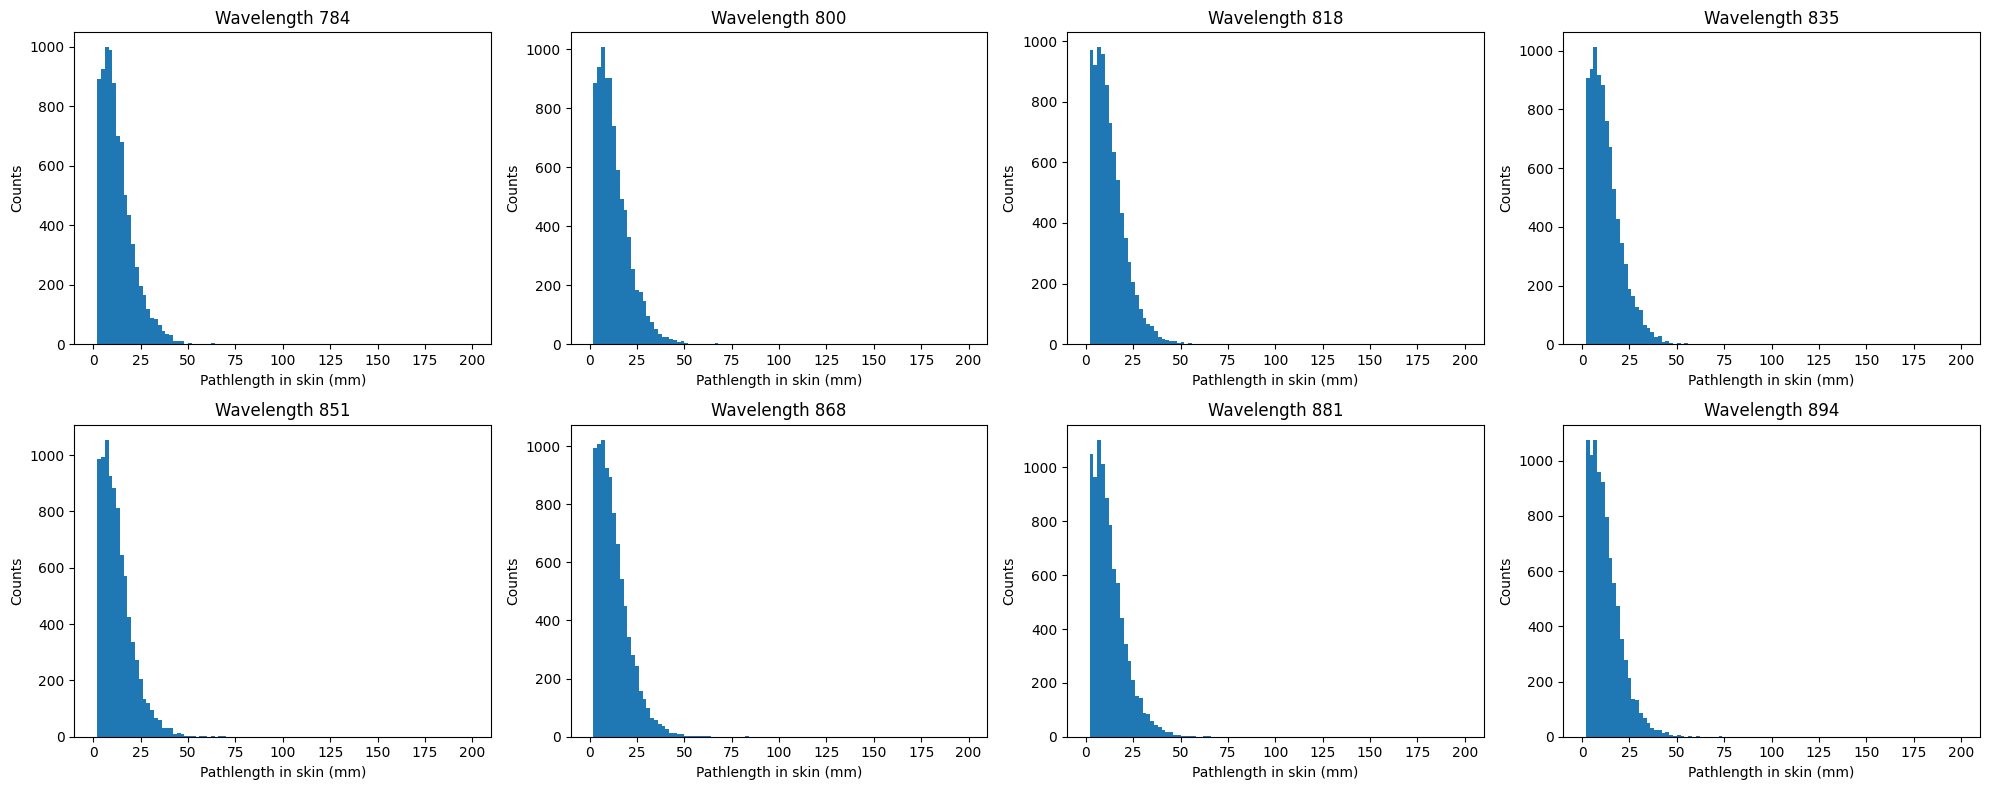

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i in range(len(wl)):
    ax = axs[i // 4, i % 4]
    result_x = re[wl[i]]
    ax.hist(result_x['detp']['ppath'][:, 0], bins=100, range=(0, 200))
    ax.set_title(f'Wavelength {wl[i]}')
    ax.set_xlabel('Pathlength in skin (mm)')
    ax.set_ylabel('Counts')

plt.tight_layout()
plt.show()

<ipython-input-17-2154030b73e0>:6: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(result_x['dref'][:, :, 0]))


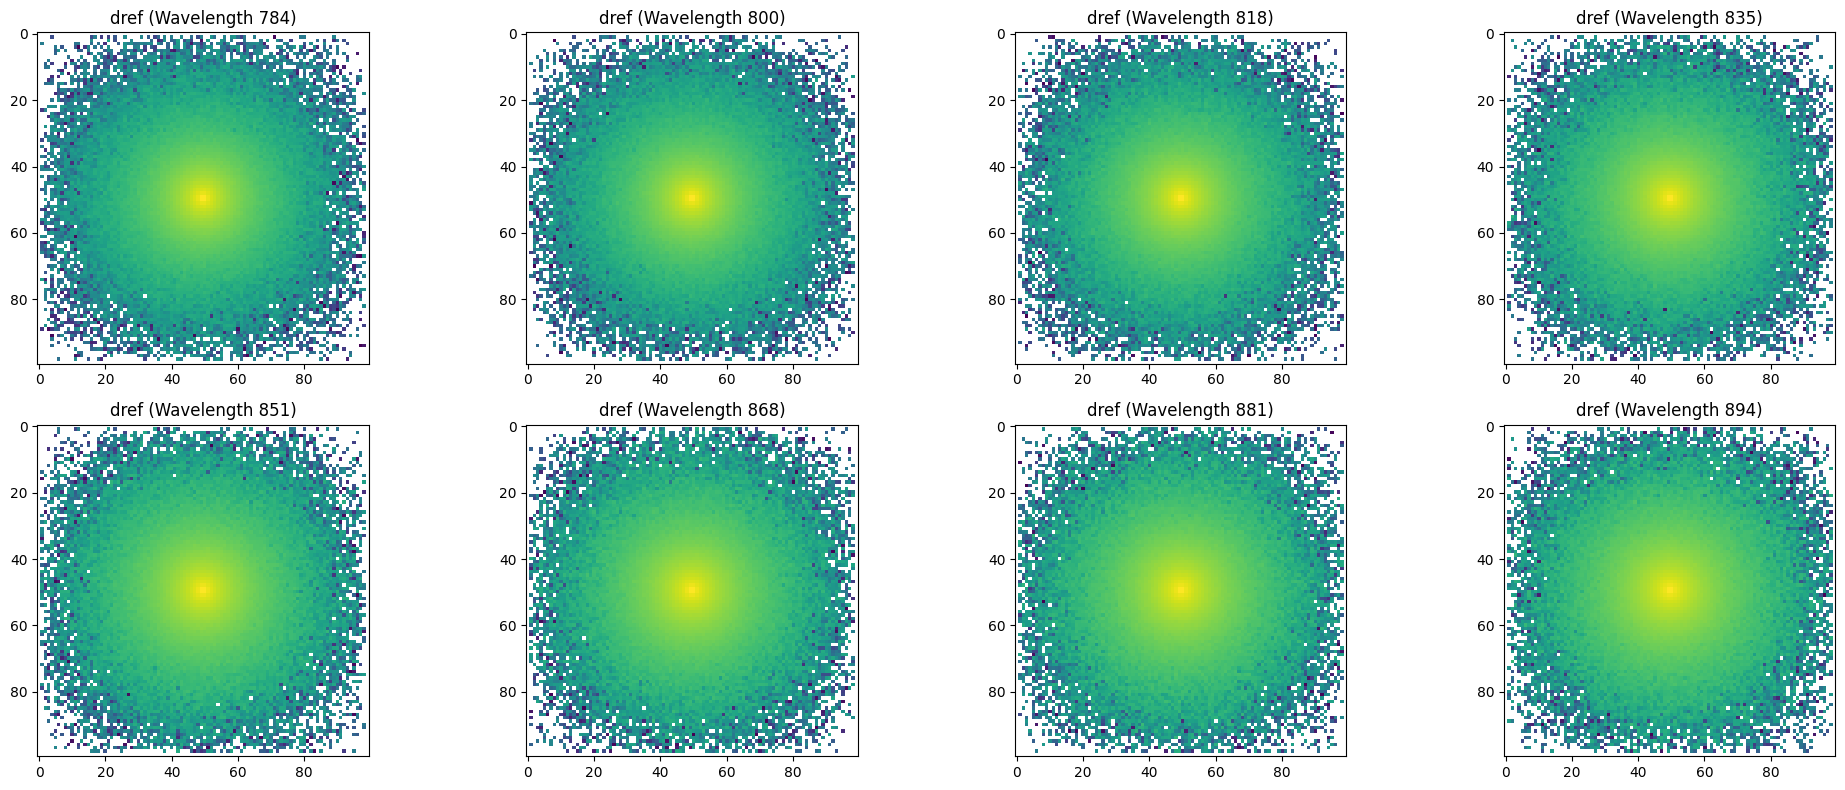

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

for i in range(len(wl)):
    ax = axs[i // 4, i % 4]
    result_x = re[wl[i]]
    ax.imshow(np.log10(result_x['dref'][:, :, 0]))
    ax.set_title(f'dref (Wavelength {wl[i]})')

plt.tight_layout()
plt.show()

### Effective mu_a computation

In [ ]:
# mu_a -> (8, 4)
k = 0
for i in wl:
  ppath = re[i]['detp']['ppath']
  mu_a_cm  = mu_a[k, :] * 10
  ppath_cm = ppath / 10.0
  mu_a_eff_path = np.sum(ppath_cm * mu_a_cm) / np.sum(ppath_cm)
  print(f"GT (effective) μa in wl = {i}: {mu_a_eff_path:.5f} 1/cm")
  k = k+1

GT (effective) μa in wl = 784: 0.08701 1/cm
GT (effective) μa in wl = 800: 0.09055 1/cm
GT (effective) μa in wl = 818: 0.09693 1/cm
GT (effective) μa in wl = 835: 0.10271 1/cm
GT (effective) μa in wl = 851: 0.10790 1/cm
GT (effective) μa in wl = 868: 0.11216 1/cm
GT (effective) μa in wl = 881: 0.11495 1/cm
GT (effective) μa in wl = 894: 0.11671 1/cm


### Reverse computation

> get delta ua



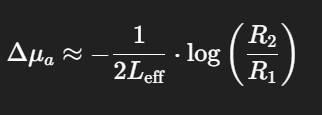

In [ ]:
import math
def get_delta_ua(r1, r2, L_eff):
  return -(1/(2*L_eff))*(np.log(r2/r1))

In [ ]:
# baseline
det_x, det_y, _, det_r = cfg['detpos'][0]
dref_bl = res_bl['dref'][:, :, 0].squeeze(2)
ny, nx = dref_bl.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum_bl = np.sum(dref_bl[mask])

# detector
dref = res['dref'][:, :, 0].squeeze(2)  # shape: (Ny, Nx)
ny, nx = dref.shape
Y, X = np.meshgrid(np.arange(ny), np.arange(nx), indexing='ij')  # shape: (ny, nx)
mask = (X - det_x) ** 2 + (Y - det_y) ** 2 <= det_r ** 2
dref_sum = np.sum(dref[mask])
print(dref_sum_bl, dref_sum)

#
Leff = np.sum(np.mean(res['detp']['ppath'], axis=1))
Leff_bl = np.sum(np.mean(res_bl['detp']['ppath'], axis=1))
print(Leff, Leff_bl)

# Baseline - experimental
print('ua_bl - ua_experiment=', get_delta_ua(dref_sum, dref_sum_bl, 30), '/mm')
print('ua_bl(gt) - ua_experiment(gt)=', 0.02 - 0.0009025, '/mm' )

65029.42 169713.56
568105.56 568105.56
ua_bl - ua_experiment= 0.015987871 /mm
ua_bl(gt) - ua_experiment(gt)= 0.0190975 /mm
